Accuracy on training data: 1.0
Accuracy on test data: 0.8717948717948718
LIME Explanation:
[('spread1 <= -0.71', -0.10968096742139913), ('MDVP:Fhi(Hz) > 0.28', -0.07914564223812251), ('MDVP:Fo(Hz) > 0.64', -0.07321038091520658), ('0.07 < DFA <= 0.78', 0.05776921003611176), ('MDVP:Flo(Hz) > 0.58', -0.05029340346516792)]


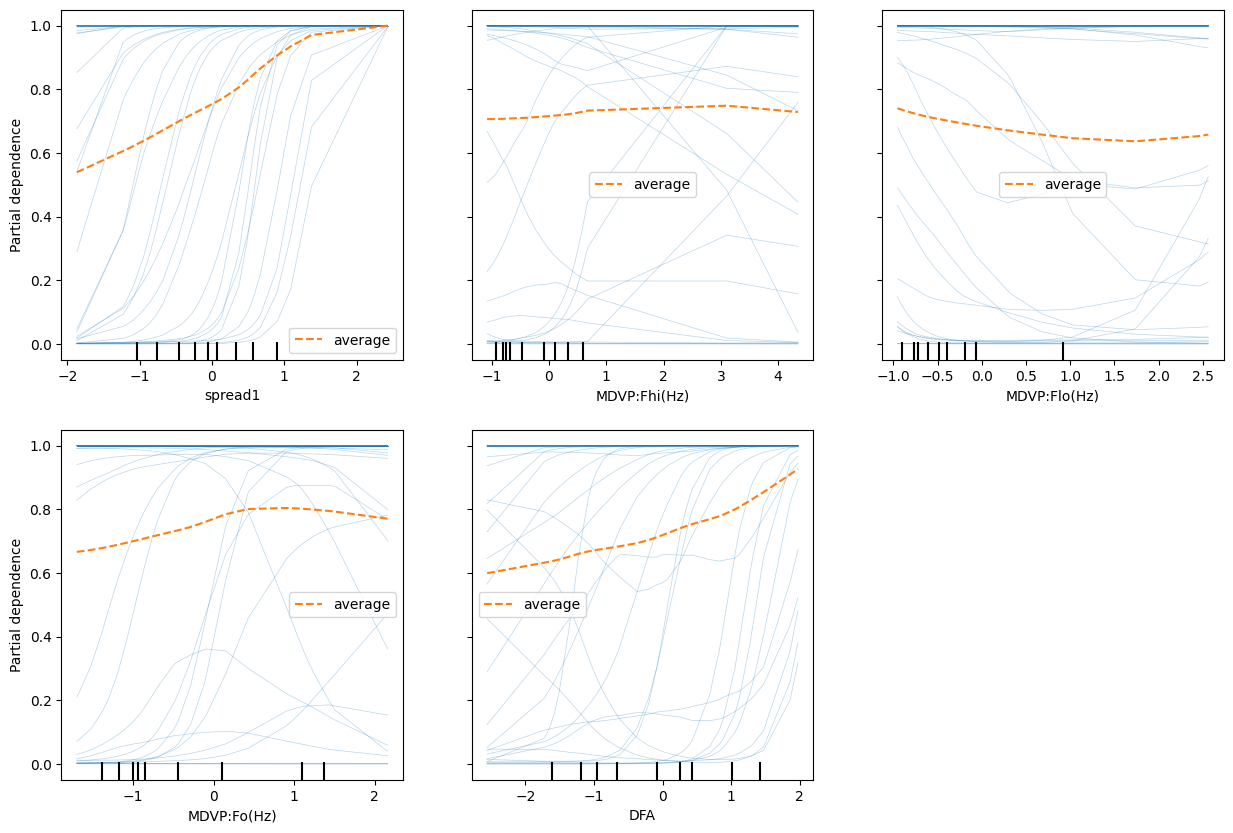

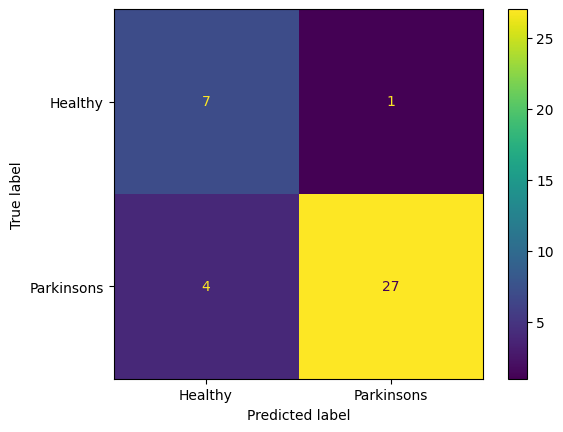

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import pickle
from lime.lime_tabular import LimeTabularExplainer
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Load CSV data into a pandas DataFrame
parkinsons_data = pd.read_csv(r"C:\Users\Ramachandra\OneDrive\Desktop\6th sem miniproject\parkinsons (1).csv")

# Split features and target
X = parkinsons_data.drop(columns=['name', 'status'], axis=1)
Y = parkinsons_data['status']

# Split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize MLPClassifier with modified parameters
mlp_classifier = MLPClassifier(
    hidden_layer_sizes=(150, 75, 25),  # Adjusted hidden layer sizes
    activation='relu',  # Changed activation function
    alpha=0.001,  # Adjusted regularization strength
    solver='adam',  # Changed optimizer
    max_iter=1000,  # Increased max iterations
    random_state=2,
)

# Train MLP classifier with modified parameters
mlp_classifier.fit(X_train_scaled, Y_train)

# Model evaluation using accuracy score
train_accuracy = accuracy_score(Y_train, mlp_classifier.predict(X_train_scaled))
test_accuracy = accuracy_score(Y_test, mlp_classifier.predict(X_test_scaled))

print("Accuracy on training data:", train_accuracy)
print("Accuracy on test data:", test_accuracy)

# Save the MLP model using pickle
filename = 'parkinsons_mlp_model.sav'
pickle.dump(mlp_classifier, open(filename, 'wb'))

# Create a LimeTabularExplainer
explainer = LimeTabularExplainer(X_train_scaled, feature_names=X.columns.tolist(), class_names=['Healthy', 'Parkinsons'])

# Example input data
input_data = np.array([197.07600, 206.89600, 192.05500, 0.00289, 0.00001, 0.00166, 0.00168, 0.00498, 0.01098, 0.09700, 0.00563, 0.00680, 0.00802, 0.01689, 0.00339, 26.77500, 0.422229, 0.741367, -7.348300, 0.177551, 1.743867, 0.085569]).reshape(1, -1)

# Generate explanations for a single instance
exp = explainer.explain_instance(input_data[0], mlp_classifier.predict_proba, num_features=5)

print('LIME Explanation:')
print(exp.as_list())
exp.show_in_notebook()

# PDP and ICE plots using sklearn.inspection
features_to_plot = ['spread1','MDVP:Fhi(Hz)','MDVP:Flo(Hz)','MDVP:Fo(Hz)','DFA']

# Plot PDP and ICE for selected features
fig, ax = plt.subplots(figsize=(15, 10))
display = PartialDependenceDisplay.from_estimator(
    mlp_classifier, 
    X_test_scaled, 
    features=features_to_plot, 
    feature_names=X.columns, 
    kind="both",  # plot both PDP and ICE
    ax=ax
)
plt.show()

# Draw confusion matrix
Y_pred = mlp_classifier.predict(X_test_scaled)
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Parkinsons'])
disp.plot()
plt.show()
